### Load in necessary libraries

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

### Create functions to load database

In [11]:
def connect_to_sql_database(database_file_name):
    import sqlite3
    connection = sqlite3.connect(database_file_name)
    cursor = connection.cursor()
    return connection, cursor

In [18]:
conn, c = connect_to_sql_database('database1.sqlite')

In [19]:
def sql_query_to_df(cursor, sql_query):
    import pandas as pd
    c.execute(sql_query)
    df = pd.DataFrame(c.fetchall())
    df.columns = [x[0] for x in c.description]
    return df

In [20]:
def get_all_tables_from_sql_database(cursor):
    df = sql_query_to_df(c, """SELECT 
                                    name
                                FROM 
                                    sqlite_master 
                                WHERE 
                                    type ='table' AND 
                                    name NOT LIKE 'sqlite_%';""")
    return df

In [21]:
get_all_tables_from_sql_database(c)

,name
0,Player_Attributes
1,Player
2,Match
3,League
4,Country
5,Team
6,Team_Attributes


In [22]:
df = sql_query_to_df(c, """SELECT * FROM Match""")
df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [74]:
df.columns


Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA', 'HomeWin', 'AwayWin',
       'Draw'],
      dtype='object', length=118)

### Get summary statistics of columns of interest

In [55]:
# Goals look good, and ID's look good
df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].isna().sum()

home_team_api_id    0
away_team_api_id    0
home_team_goal      0
away_team_goal      0
dtype: int64

In [56]:
#Examining summary statistics of the four columns I plan to use
df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].describe()

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
count,25979.000000,25979.000000,25979.000000,25979.000000
mean,9984.371993,9984.475115,1.544594,1.160938
std,14087.453758,14087.445135,1.297158,1.142110
min,1601.000000,1601.000000,0.000000,0.000000
25%,8475.000000,8475.000000,1.000000,0.000000
50%,8697.000000,8697.000000,1.000000,1.000000
75%,9925.000000,9925.000000,2.000000,2.000000
max,274581.000000,274581.000000,10.000000,9.000000


In [57]:
#All are integers
df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 4 columns):
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
dtypes: int64(4)
memory usage: 811.9 KB


### Explore columns of interest visually

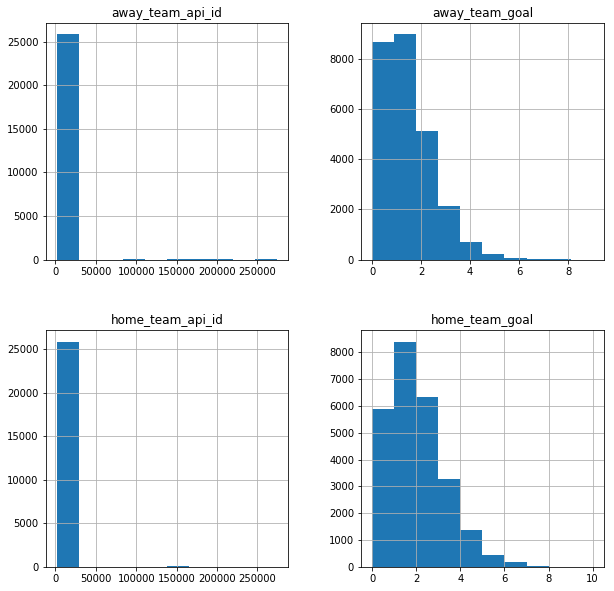

In [58]:
graph = df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].hist(figsize=(10,10))

In [87]:
logHomeGoals = np.log(df['home_team_goal'])

/Users/flatironstudentaccount/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


0

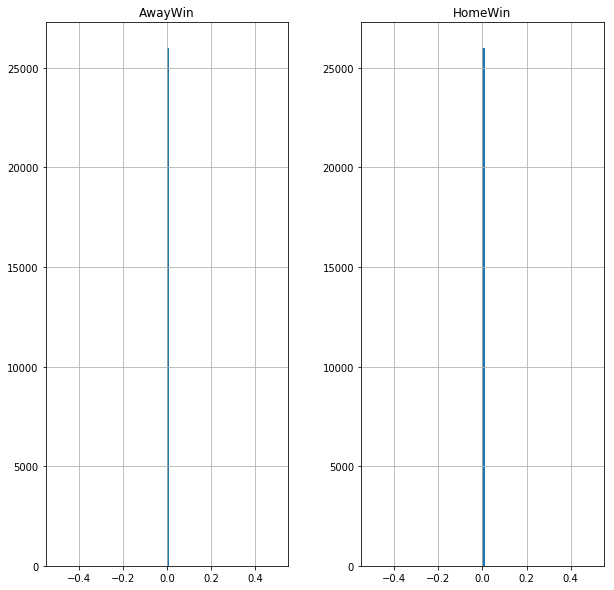

In [86]:
#will need to use log transformation for goal metrics to be able to conduct T-tests
graph = np.log(np.isfinite(df[['HomeWin', 'AwayWin']])).hist(figsize=(10,10), bins = 100)

### Create columns for Home/Away/Draw and try to get a name from API 

In [61]:
#(From Joe): Sets up columns to see who won or lost or draw
df['HomeWin']=df.home_team_goal>df.away_team_goal
df['AwayWin']=df.away_team_goal>df.home_team_goal
df['Draw']=df.home_team_goal==df.away_team_goal

In [63]:
#(From Joe)
df.HomeWin.sum()/df.HomeWin.shape[0]

0.45871665576042187

In [64]:
#The effect size of playing home/away appears to be substantial
df.AwayWin.sum()/df.AwayWin.shape[0]

0.28738596558759

In [65]:
df.Draw.sum()/df.Draw.shape[0]

0.25389737865198814

In [51]:
home_teams = df['home_team_api_id'].unique()

In [52]:
def compute_if_home_team_won(df):
    summary_list = []
    for team in home_teams:
        home_goals = df['home_team_goal'].sum()
        away_goals = df['away_team_goal'].sum()
        if home_goals > away_goals:
            summary_list.append(home_teams)
        return summary_list
        

In [53]:
compute_if_home_team_won(df)

[array([  9987,  10000,   9984,   9991,   7947,   8203,   9999,   4049,
         10001,   8342,   9985,   9994,   9996,   9993,   8635,   9998,
          9986,   8571,   9997,   9989,   6351,   1773,   8475,   8573,
        274581,  10260,   9825,   8472,   8654,  10252,   8668,   8549,
          8559,   8667,   8455,  10194,   8650,  10261,   9879,   8586,
          8659,   8462,   8456,   8655,   8528,   8602,   8191,   8658,
          8483,  10172,   9850,  10003,   9798,   8466,   9826,   8344,
          8197,   8678,   9817,   8583,   9827,   9746,   8682,   9748,
          9829,   8481,   9851,   9874,   9873,   8639,   8689,   8592,
          9831,   9853,   9941,   7819,   9855,   9830,   9847,  10249,
          4170,   8588, 108893,   8521,   8576,   9836,   4087,   9837,
         10242,   7794,   9747,   8550,   8121,   6391,   9823,   8178,
         10189,   8721,   9810,   9912,   8398,   9788,   8295,   9790,
          8697,   8177,   8722,   9911,   9789,  10269,   9904, 

In [66]:
#w/o Log Normalization
x = df.HomeWin
y = df.AwayWin
ttest=stats.ttest_ind(x,y)
print('t-test independent', ttest)

t-test independent Ttest_indResult(statistic=41.02469141216727, pvalue=0.0)


In [70]:
#w/ Log Normalization
x = np.log(np.isfinite(df.HomeWin))
y = np.log(np.isfinite(df.AwayWin))
ttest=stats.ttest_ind(x,y)
print('t-test independent', ttest)

t-test independent Ttest_indResult(statistic=nan, pvalue=nan)


In [75]:
#w/ Log Normalization
x = np.log(df.HomeWin)
y = np.log(df.AwayWin)
ttest=stats.ttest_ind(x,y)
print('t-test independent', ttest)

t-test independent Ttest_indResult(statistic=nan, pvalue=nan)


/Users/flatironstudentaccount/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/flatironstudentaccount/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/flatironstudentaccount/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/flatironstudentaccount/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3936: RuntimeWarning: invalid value encountered in half_scalars
  d = mean1 - mean2


In [76]:
df.HomeWin.mean()

0.45871665576042187

In [77]:
df.AwayWin.mean()

0.28738596558759